# Inference

Test the trained and saved on model on the images of the Red Sea. The images are stored in `"/data/jonathan/eilat_gopro/"`.

## Imports

In [1]:
# import the necessary packages
from skimage import io
from torchvision import transforms
import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import torch

In [2]:
torch.manual_seed(42)

## Plot function

In [3]:
classes = {1: 'hard coral',
           2: 'hard coral bleached',
           3: 'dead coral',
           4: 'other invertebrates',
           5: 'sand/rubble',
           6: 'other',
           7: 'algae',
           8: 'unknown',
           0: 'no label'
          }

In [4]:
def prepare_plot(image, predMask):
    # initialize our figure
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 10))
    
    unnormalize = transforms.Compose([transforms.Normalize(mean = [ 0., 0., 0. ],
                                                           std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                      transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                           std = [ 1., 1., 1. ])])

    # plot the original image, and the predicted mask
    im1 = ax[0].imshow(unnormalize(image[0]).cpu().detach().permute(1, 2, 0))
    im2 = ax[1].imshow(predMask, cmap = plt.cm.get_cmap('tab20', 9), vmin=0, vmax=8)
    
    # add the colorbar
    cbar = fig.colorbar(im2, ticks=list(classes.keys()), fraction=0.045, pad=0.05)
    cbar.ax.set_yticklabels(list(classes.values()))
    
    # set the titles of the subplots
    ax[0].set_title("Image")
    ax[1].set_title("Predicted Mask")
    
    # set the layout of the figure and display it
    fig.show()

## Testing loop

In [5]:
def make_predictions(model, imagePath):
    # set model to evaluation mode
    model.eval()
    
    # turn off gradient tracking
    with torch.no_grad():
        # load the image from disk
        image = io.imread(imagePath)
        
        # apply transformation
        transformed = test_transform(image=image)
        image = transformed["image"]
        
        # create image tensor
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image)
        image = image.to("cuda")

        # prediction
        predMask = unet(image).squeeze()
        predMask = torch.argmax(predMask, dim=0)
        predMask = predMask.cpu().numpy()

        # convert the predictions to integers
        predMask = predMask.astype(np.uint8)
        
        # prepare a plot for visualization
        prepare_plot(image, predMask)

In [6]:
test_transform = A.Compose([
    A.RandomResizedCrop(width=128, height=128, scale=(0.08, 1.0), ratio=(0.75, 1.33)),    
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
])

## Make predictions

[INFO] loading up test image paths...
[INFO] load up model...


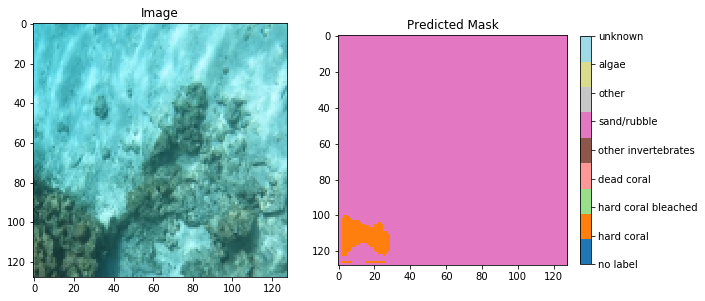

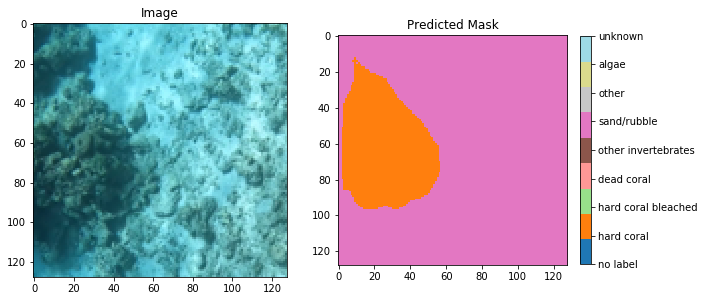

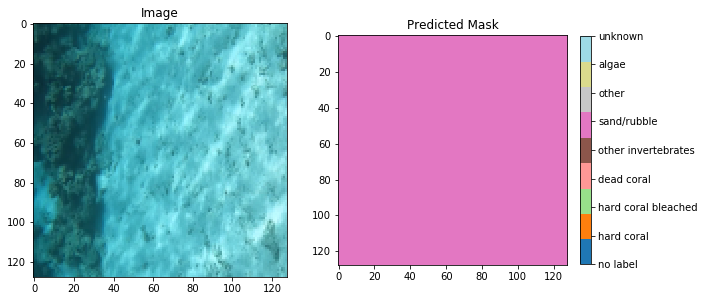

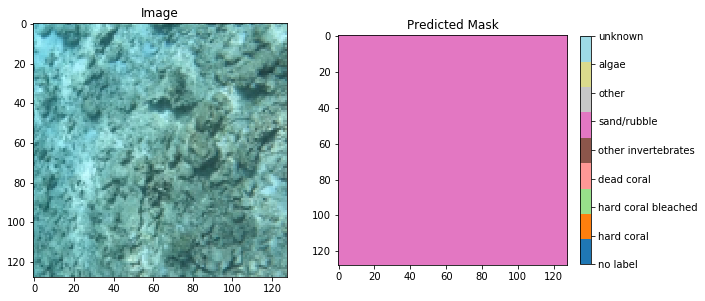

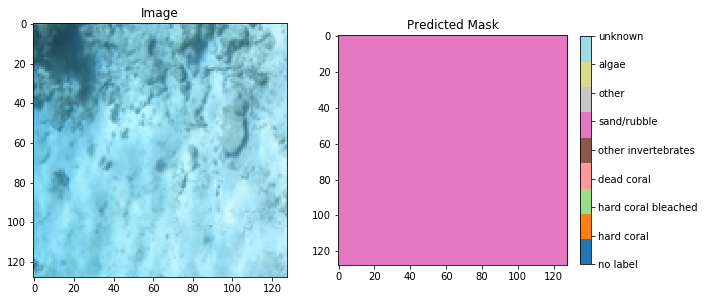

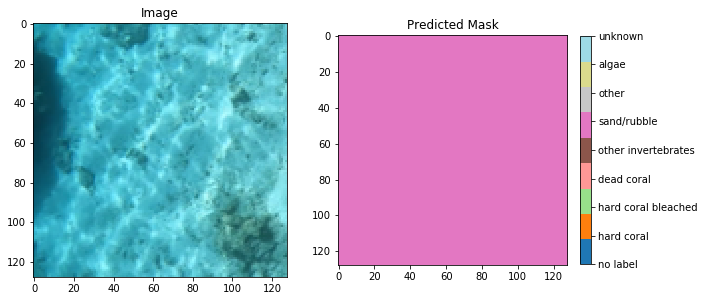

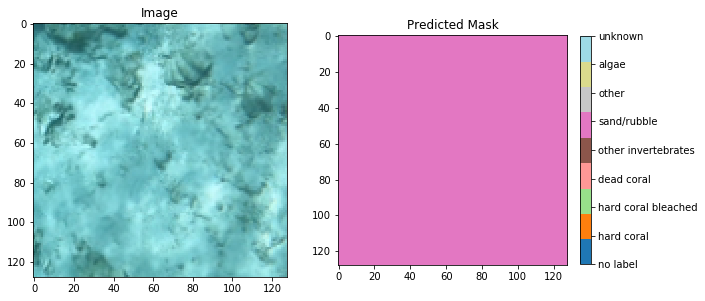

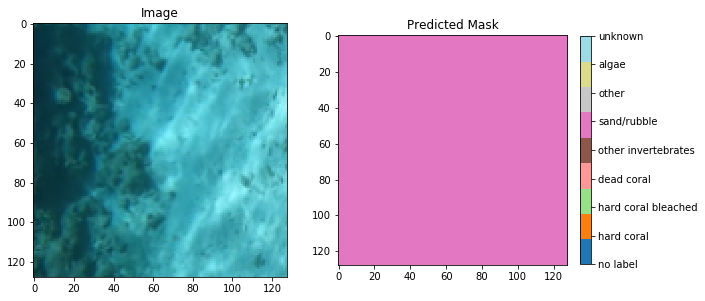

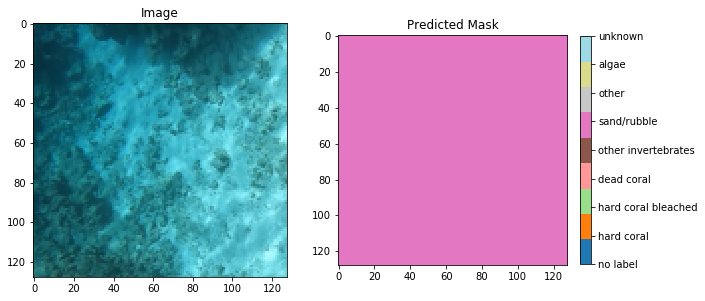

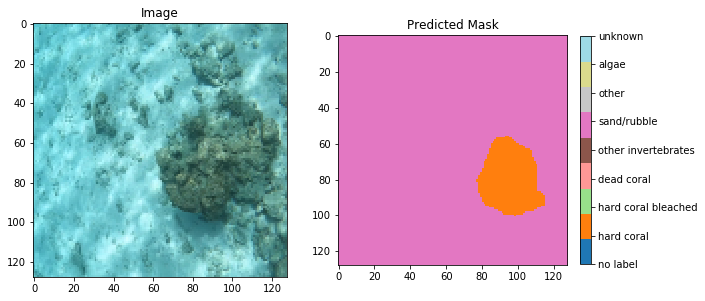

In [7]:
# load the image paths in our testing file and randomly select 10 image paths
print("[INFO] loading up test image paths...")
directory = "/data/jonathan/eilat_gopro/scene_7/"
imagePaths = os.listdir(directory)
imagePaths = np.random.choice(imagePaths, size=10)

# load our model from disk and flash it to the current device
print("[INFO] load up model...")
unet = torch.load("/data/jantina/CoralNet/dataset/output/unet.pth").to("cuda")

# iterate over the randomly selected test image paths
for path in imagePaths:
    make_predictions(unet, directory+path)

## Check out some images

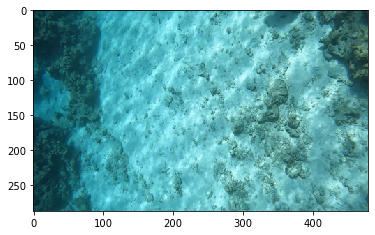

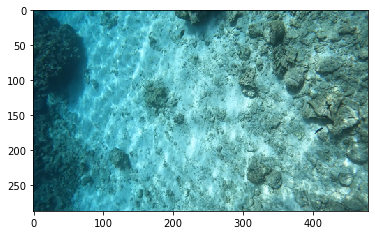

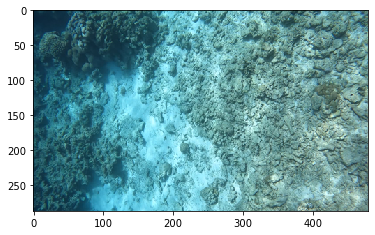

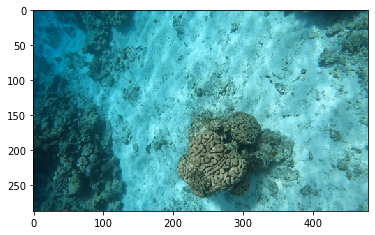

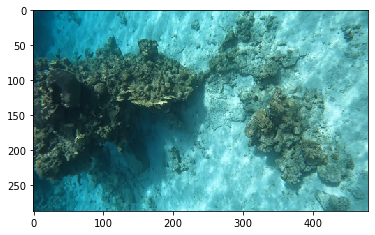

In [8]:
directory = "/data/jonathan/eilat_gopro/scene_7/"

files = os.listdir(directory)
d = random.sample(files, 5)
for im in d:
    image = io.imread(directory+im)
    plt.imshow(image)
    plt.show()